In [17]:
from data_initialization_spikeSorting import *
from preprocess_data import *
from locate_snippets_test import *
from preprocess_data import *
from cluster_snippets_plot import plot_clusters
import local_directories as ldir
from preprocess_data import preprocess_data
from segment_data import segment_data
from locate_snippets import locate_snippets
from upsample_snippets import upsample_snippets
import matplotlib.pyplot as plt
import numpy as np
from segment_data_newKer import *
from cluster_snippets import cluster_snippets
from cluster_snippets_plot import plot_clusters

In [3]:
# generating stimulation data 

num_cell=3
num_electron=2
time =100000
delay=False
noise_level=5
spike_len=200
boolean=np.ones((num_cell,num_electron))

spike_shape_parameter=multi_electrons_shape_generator(num_cell,num_electron)
overlap_level=200
    
signal_r,timeline_list,signal_matrix,delay_matrix,num_spike=multi_electrons_signal_generator(num_cell,
num_electron,spike_shape_parameter,time,delay,overlap_level,noise_level,boolean,spike_len)

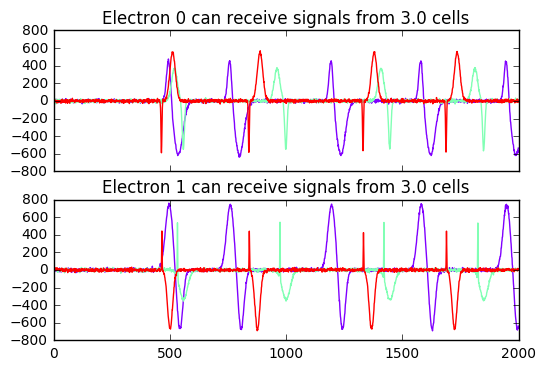

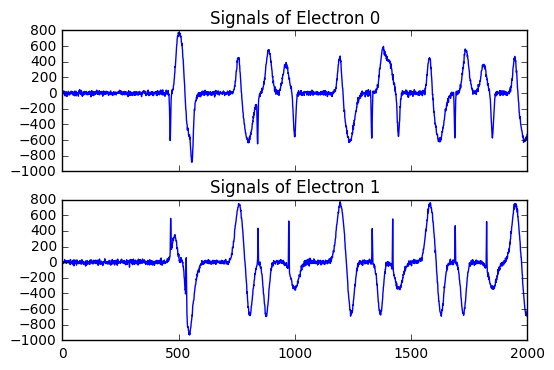

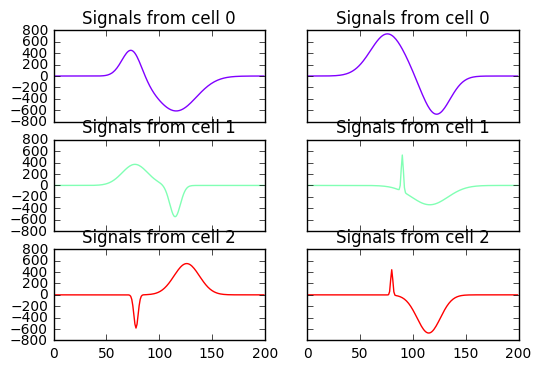

In [4]:
plot_size=5000


plot_data(num_cell,num_electron,signal_matrix,signal_r,spike_shape_parameter,boolean,spike_len,plot_size=2000)






/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  b = a[a_slice]


0.01


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


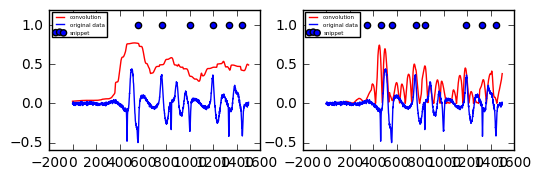

0.01


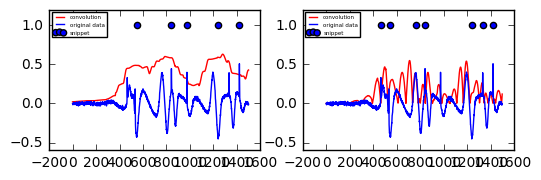

In [14]:
wl=201
max_fraction=1
min_fraction=0.8
plot_size=1500
wl2=(wl+1)/2

# segment data using new kernel / compare with old kernel
for i in range(num_electron):
    data=preprocess_data(signal_r[i])
    ind_ini, ind_end = segment_data(data, wl, max_fraction, min_fraction)
    extrema = locate_snippets(data, ind_ini, ind_end, wl)
    
    ind_ini2, ind_end2=segment_data_newK(data,wl2,max_fraction,min_fraction)
    extrema2=locate_snippets(data,ind_ini2,ind_end2, (wl-1)/2+1)
    
    windowed_data=convolution_kernel(data,wl)
    windowed_data2=convolution_kernel2(data,wl2)
    
    #plot
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.plot(windowed_data[0:plot_size],'r',label="convolution")
    ax1.plot(data[0:plot_size],label="original data")
    extrema_size = [i for i in extrema if i <= plot_size]
    ax1.scatter(extrema_size,np.ones(len(extrema_size)),label="snippet")
    ax1.legend(loc="upper left",prop={'size':4})
    
    ax2.plot(windowed_data2[0:plot_size],'r',label="convolution")
    ax2.plot(data[0:plot_size],label="original data")
    extrema2_size = [i for i in extrema2 if i <= plot_size]
    ax2.scatter(extrema2_size,np.ones(len(extrema2_size)),label="snippet")
    ax2.legend(loc="upper left",prop={'size':4})
    
    plt.show()


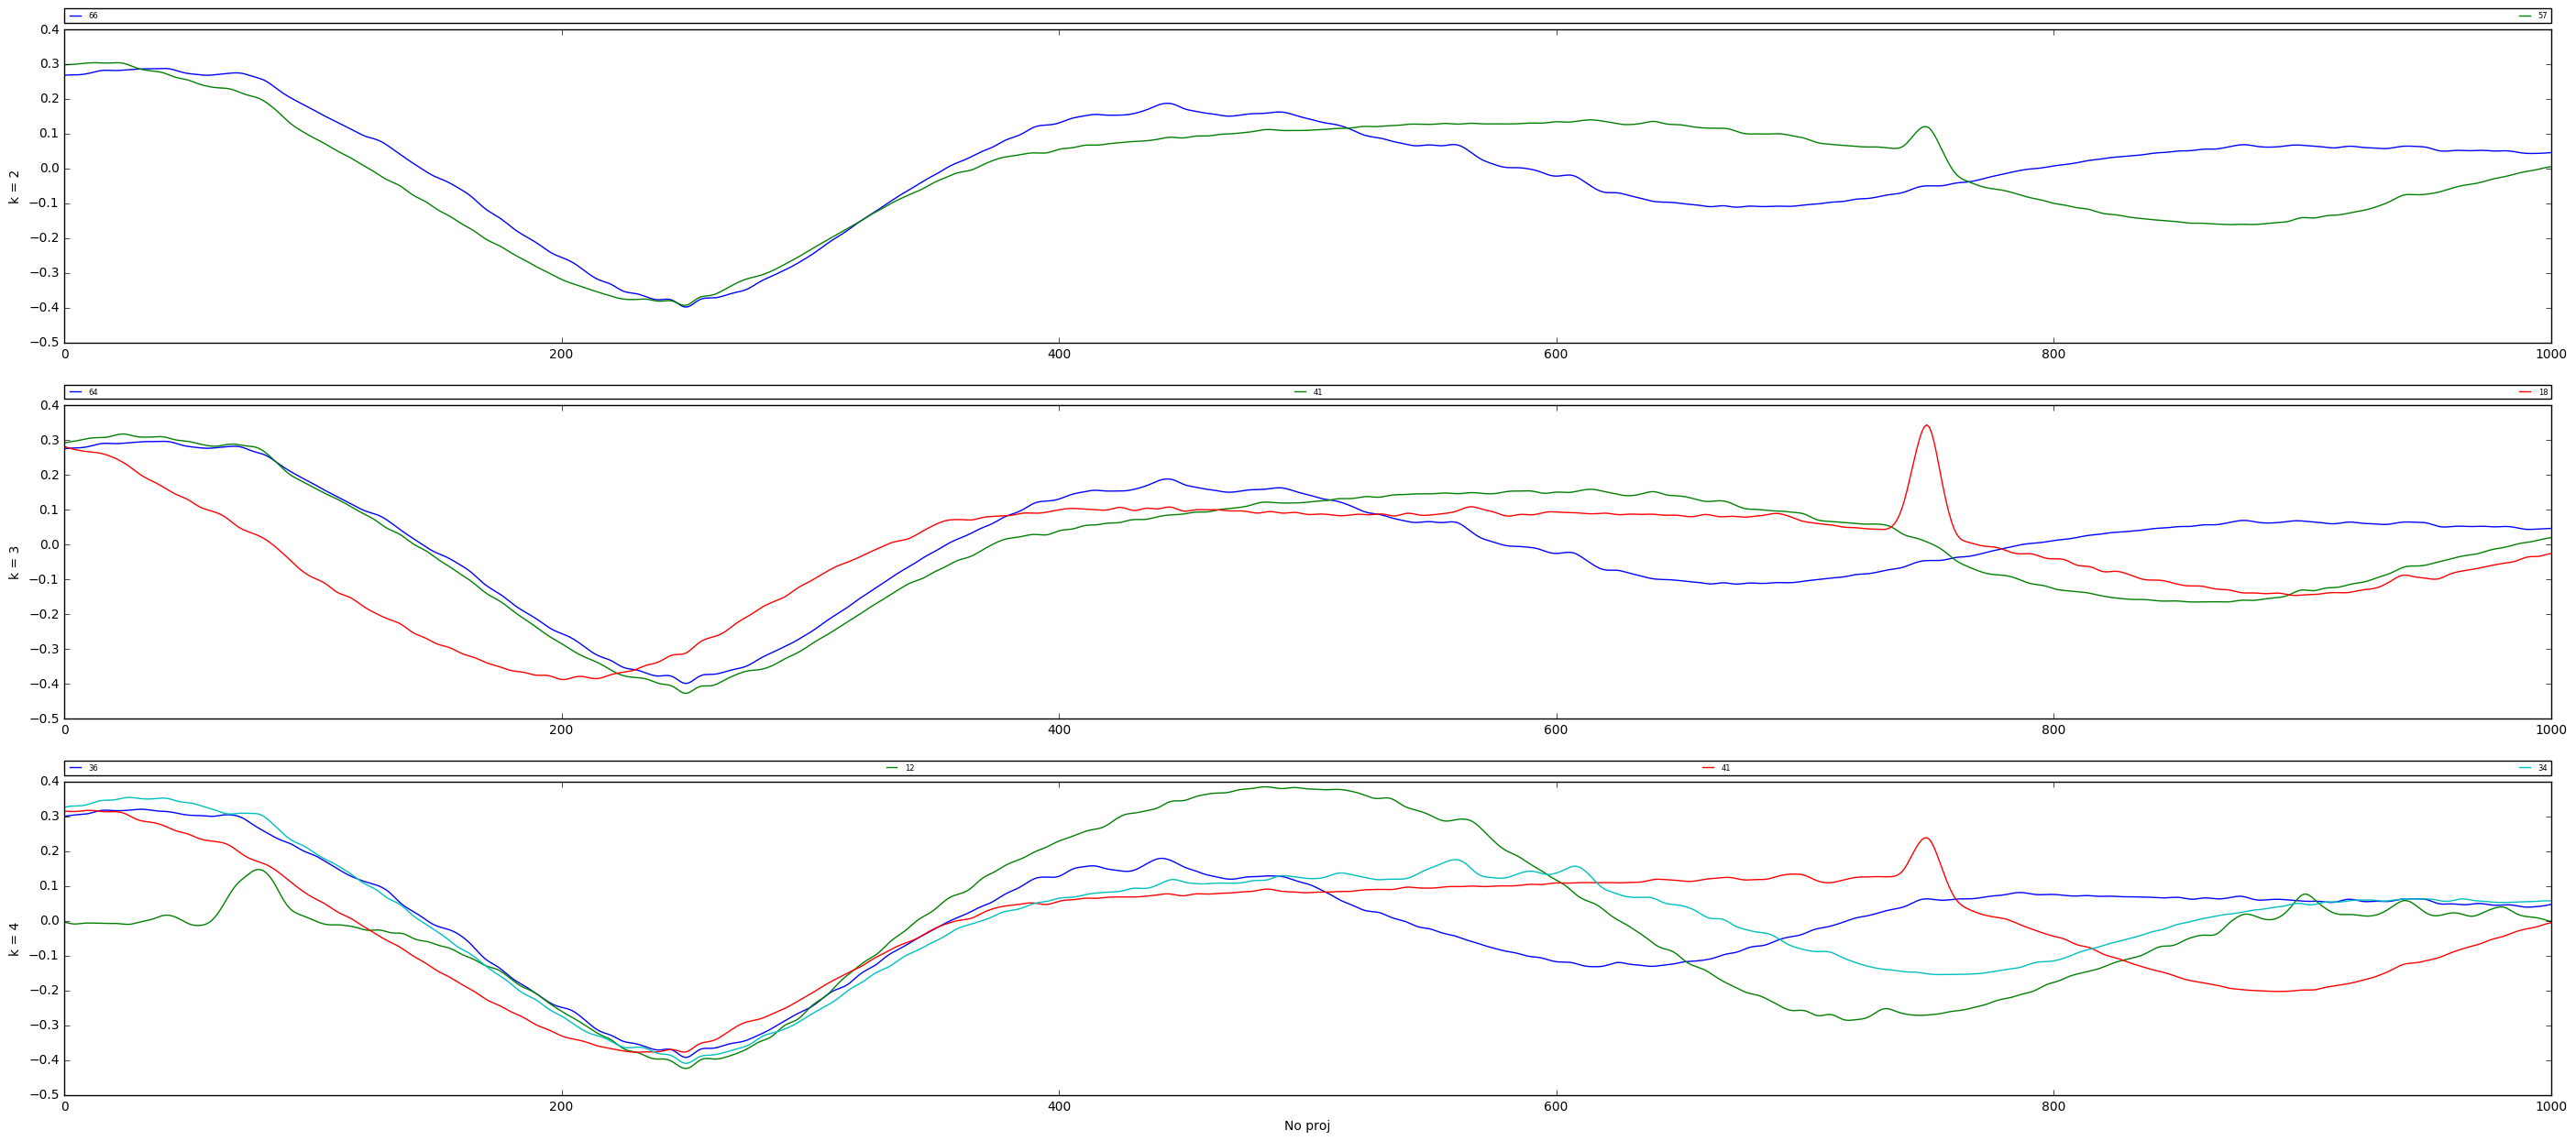

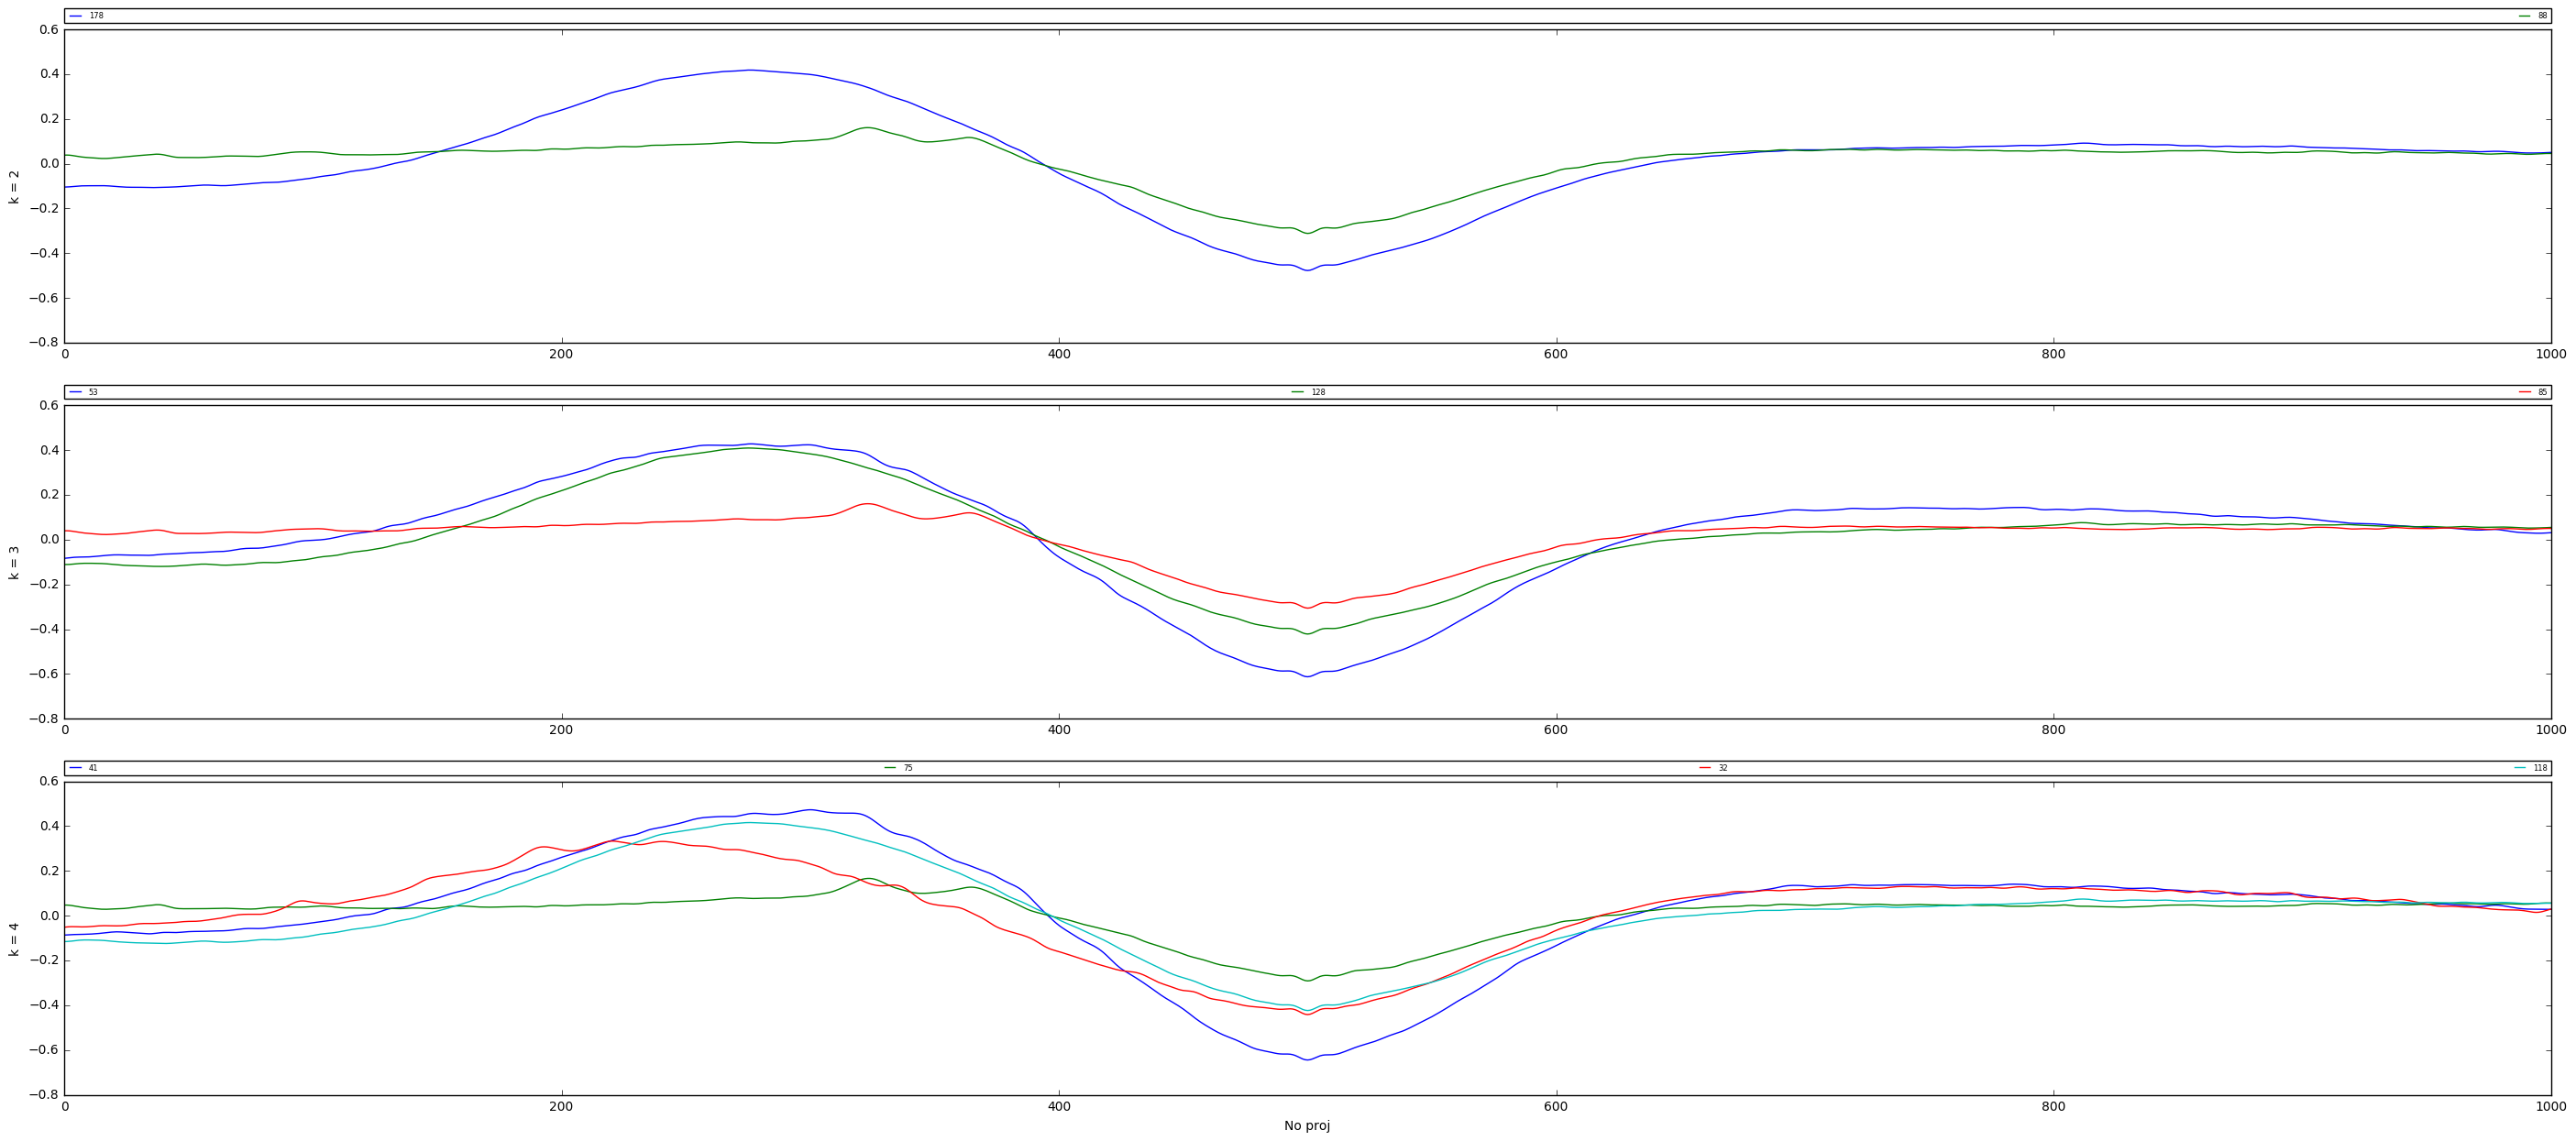

In [20]:
# upsample and cluster
uf = 5
k_val=range(2,5)
n_pc_val = [0]
row_titles = ["k = 2", "k = 3", "k = 4"]
col_titles = ["No proj", "PC = 2 (av)", "PC = 2",
                "PC = 5 (av)", "PC = 5", "PC = 40 (av)",
                "PC = 40"]
upsamp_res = upsample_snippets(data, extrema, wl, uf)
for wav_type in ["minmax", "maxmin"]:
    snippets = upsamp_res[wav_type + "_snips"]
    locations = upsamp_res[wav_type + "_loc"]
    wav_list = []
    for k in k_val:
        wav_list_k = []
        for n_pc in n_pc_val:
          # print "n pc: " + str(n_pc)
            if n_pc == 0:
                PCA = False
            else:
                PCA = True 
            av = True
            res = cluster_snippets(snippets, locations, data, k, PCA, n_pc, av)
            n_points = []
            for i in range(len(res["loc"])):
                n_points.append(len(res["loc"][i]))
            wav_list_k.append([res["wav"], n_points])
            if PCA:
                av = False
                res = cluster_snippets(snippets, locations, data, k, PCA, n_pc, av)
                n_points = []
                for i in range(len(res["loc"])):
                    n_points.append(len(res["loc"][i]))
                wav_list_k.append([res["wav"], n_points])
        wav_list.append(wav_list_k)
    plot_clusters(wav_list, row_titles, col_titles, save_fig="plot_fig")
plt.show()




In [ ]:
def convolution_kernel(data,h):
    windowed_data_sq = np.convolve(data ** 2, np.ones(h + 1), "same")
    windowed_data_aux = np.sqrt(windowed_data_sq)
    windowed_data = windowed_data_aux / np.amax(np.abs(windowed_data_aux))
    
    return windowed_data


def convolution_kernel2(data,h):
    window_l = np.hstack((np.ones((h-1)/2), -np.ones((h+1)/2)))
    windowed_data_l = np.convolve(data , window_l,"same")
    windowed_data2 = np.maximum(windowed_data_l,-windowed_data_l)
    windowed_data2 = windowed_data2/np.amax(np.abs(windowed_data2))

    return windowed_data2
    
    
# windowed_data=windowed_data[0:2000]
# threshold=np.mean(windowed_data)
# spike_loc=detect_peaks(windowed_data, mph=threshold, mpd=spike_len/2, show=False)

# plt.plot(windowed_data[0:2000],'r')
# plt.plot(data[0:2000],'g')
# plt.scatter(spike_loc,np.ones(len(spike_loc)))

# plt.show()


# print(spike_loc)